## KFAC in laplax

In the [Laplace Redux](https://arxiv.org/abs/2106.14806) paper, the authors share their laplace approximation library for second order optimization and Bayesian Machine Learning. The corresponding framework [laplace-torch](https://github.com/AlexImmer/Laplace) gives PyTorch implementations for all common curvature matrix- and approximation-types.

The goal of the library [laplax](https://github.com/laplax-org/laplax) is to provide the same functionality in pure jax. Additionally, as there isn't one prominent frontend library for deep learning in jax (flax.linen, flax.nnx, equinox, haiku), laplax targets all of these frontends by relying on a purely functional style, in which the user simply specifies a model function $f : \mathcal D \times \mathcal \Theta \to \mathcal Y$, which maps a tuple of inputs and parameters to an output. Further, laplax relies on Matrix-Vector functions, instead of storing matrices in memory. This harmonizes well with jax's functional paradigm. A drawback of this approach becomes apparent when we need to condition on structure of the given model in order to compute approximations. Especially, the Kronecker Factored Approximation to Curvature (KFAC) needs to access layers, store intermediate results and compute gradients w.r.t. those intermediates. This becomes a challenge due to the purely functional nature of laplax. Libraries like [kfac-jax](https://github.com/google-deepmind/kfac-jax) try to infer as much information as possible from the given model, however their approach is for one tailored towards KFAC-Optimizers and on the other hand it's necessary to conform to special (admittedly unavoidable) constraints in order to write a training loop which incorporates their optimizer.

We'd like a more lightweight and flexible method of just obtaining the KFAC blocks - or even just the intermediate activations and gradients - without having to add too many dependencies and convolute the solution. In a perfect world, we could write code that magically just does the job:

```python
from module import intermediates_and_gradients
from models import MLP
from data import make_dataset

model = MLP(din=10, dhidden=5, dout=2)
x, y = make_dataset()

# computes the pre-relu activations and the gradients of the loss w.r.t. layer outputs
activations, grads = intermediates_and_gradients(model, x, y, loss_fn='celoss')
```

#### What this notebook isn't
This notebook is a work in progress, names, locations and functionality will change. It's not a demo of laplax library code. The notebook is supposed to be a jumpstart for everyone interested in writing a stable KFAC implementation for laplax, it's not a polished solution.

In case you aren't using laplax and just need the intermediates and the gradients of the intermediate values, take a look at [this](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/module.html#flax.nnx.Module.perturb) documentation page, which gives a method to collect intermediate gradients safely.

## Problem definition - KFAC basics

I'll brush over what is a really well explained in Felix Dangel's [kfac-tutorial](https://github.com/f-dangel/kfac-tutorial).

Assume a Loss function $\mathcal L : \mathcal Y \times \mathcal Y \to \mathbb R$, and a prediction model (Neural Network) $f_{\theta} : \mathcal X \to \mathcal Y$. We'd like to use local curvature information around a point in the parameter space to use in our method. However, when the number of parameters is large, computing the exact curvature becomes impossible due to time and memory constraints - we need a good approximation to the curvature. A diagonal approximation - computing the covariance of each parameter with itself - is a good start. However for some applications it may be beneficial to trade off computation for a more accurate curvature approximation. Besides a low-rank approximation to curvature, KFAC offers this.  

The KFAC algorithm we'll discuss computes the layerwise covariances. For an MLP $f = A_n \circ \phi_{n-1} \circ A_{n-1} \circ ... \circ \phi_1 \circ A_1$, where $A_i$ are the linear layers and $\phi_i$ are the activation functions, it computes the Curvature blocks $C(\theta^{(i)})$ which relates all parameters *within* a layer. To obtain these approximations, we'll need the inputs to the $i$'th layer $x_i$ and the gradients of the loss w.r.t. the pre-activations $z_i := A_i x_i$ which we'll denote as $g_i := \frac{\partial \mathcal L}{\partial z_i}$.

Once we have those, we can compute the $i$'th layer's curvature for $N$ datapoints as $C(\theta^{(i)}) \approx A_i \otimes B_i$ for which $A_i = \sum_j^N x_{i,j} x_{i,j}^\top, \quad B_i = \frac{1}{N}\sum_j^N g_{i,j} g_{i,j}^\top$ and $\otimes$ denotes the Kronecker product of two matrices.

To categorize the KFAC-flavour we're aiming for: In the notation of F. Dangel, we're computing $\text{KFAC}_{\text{exp}}^E(\text{rvec}(\tilde W))$ - the KFAC-expand of the Empirical Fisher for the augmented weight vector $\tilde W$ with the vectorization scheme $\text{rvec}$.


## Jaxprs and writing Jax Interpreters

What makes jax so unique is that its allowing for the composition of function transformations. You might have come across 
```python 
jax.jit(jax.vmap(model))(xs) # jit-of-vmap
jax.grad(jax.grad(f)) # second derivative
```
where the vmap and jit function transformations are concatenated. Another view on function transformations is program interpretation. Each function transformation interprets a sub-program to yield another program. The interpretation of a program is a program itself, so a function transformation of a function transformation is possible.

A special function transformation which lets us a) inspect the underlying computation invoked by a function and b) lets us access the computation graph is the `jax.make_jaxpr` function transformation. It traces (jax-lingo for interprets) the function you pass it and constructs a sequence of equations which make up a program.

A prerequisite to obtaining the necessary values from the jax computation graph is to get an understanding of how to handle jax expressions. [Jaxpr](https://docs.jax.dev/en/latest/jaxpr.html) is a jax-internal expression language for side-effect-less programs which take in and return vectors. Here is a small example:

In [1]:
import jax

def f(x):
    x = x + 1
    x = x * 2
    x = jax.numpy.sin(x)
    print('This is a side-effect!')
    return x

print(jax.make_jaxpr(f)(jax.numpy.arange(10).astype(float)))

This is a side-effect!
{ lambda ; a:f32[10]. let
    b:f32[10] = add a 1.0
    c:f32[10] = mul b 2.0
    d:f32[10] = sin c
  in (d,) }


What jax is doing under the hood is first tracing, i.e. interpreting the supplied function. While tracing, the function is also executed, which triggers the print statement. In the final jaxpr however we cannot find any print statements. Note that this is also what happens when we jit-compile a function which contains a print statement. During compile-time, the function is traced and the print statement is executed once. Later, when you execute the compiled function, the print statements aren't part of the staged program any more. 

For the rest of this section, we'll write programs which take the computation tree defined by parsing the function into a jaxpr, then operating on it and inserting operations at the correct stage. Helpful resources for a more in-depth understanding on the inner workings of jax are: [Writing a jax interpreter](https://docs.jax.dev/en/latest/notebooks/Writing_custom_interpreters_in_Jax.html), [Autodidax](https://docs.jax.dev/en/latest/autodidax.html) and [Autodidax 2](https://docs.jax.dev/en/latest/autodidax2_part1.html). 


### Obtaining layer inputs ($x_{i,j}$)

To get a grip of the computation graph, lets first print the jaxpr of a forward pass of an MLP.

In [2]:
from flax import nnx
import jax.numpy as jnp

class MLP(nnx.Module):
    def __init__(self, din=5, dmid=4, dout=3, rngs=nnx.Rngs(0)):
        super().__init__()
        self.lin1 = nnx.Linear(in_features=din, out_features=dmid, rngs=rngs)
        self.lin2 = nnx.Linear(in_features=dmid, out_features=dout, rngs=rngs)
    def __call__(self, x):
        x = self.lin1(x)
        x = nnx.relu(x)
        x = self.lin2(x)
        return x

model = MLP()
x = jnp.arange(5).astype(float)
print(jax.make_jaxpr(model)(x))

{ lambda a:f32[5,4] b:f32[4] c:f32[4,3] d:f32[3]; e:f32[5]. let
    f:f32[4] = dot_general[dimension_numbers=(([0], [0]), ([], []))] e a
    g:f32[4] = add f b
    h:f32[4] = custom_jvp_call[
      call_jaxpr={ lambda ; i:f32[4]. let
          j:f32[4] = pjit[
            name=relu
            jaxpr={ lambda ; k:f32[4]. let l:f32[4] = max k 0.0 in (l,) }
          ] i
        in (j,) }
      jvp_jaxpr_thunk=<function _memoize.<locals>.memoized at 0x7626003b9580>
      num_consts=0
      symbolic_zeros=False
    ] g
    m:f32[3] = dot_general[dimension_numbers=(([0], [0]), ([], []))] h c
    n:f32[3] = add m d
  in (n,) }


In this jaxpr, the inputs to the layers are values of the variables e and h. Note that the input variables a to d are the weights and biases of the network. The `custom_jvp_call` corresponds to the relu operation. Next, we'll write a function which can evaluate any given jaxpr. We can show that the jaxprs from the regular function $f$ and the function which evaluates the jaxpr of $f$ are equivalent. We obtain a way of manually traversing the computation graph. This will come in handy when trying to extract the values e and h (or possibly many more values) from the computation graph. 

In [3]:

# Importing Jax functions useful for tracing/interpreting.
from functools import wraps

from jax import lax
from jax.extend import core
from jax._src.util import safe_map

def eval_jaxpr(jaxpr, consts, *args):
  # Mapping from variable -> value
  env = {}

  def read(var):
    # Literals are values baked into the Jaxpr
    if type(var) is core.Literal:
      return var.val
    return env[var]

  def write(var, val):
    env[var] = val

  # Bind args and consts to environment
  safe_map(write, jaxpr.invars, args)
  safe_map(write, jaxpr.constvars, consts)

  for i, eqn in enumerate(jaxpr.eqns):
    invals = safe_map(read, eqn.invars)
    
    if "call_jaxpr" in eqn.params: # handle custom definitions (i.e. jax.nn.relu)
        subjaxpr = eqn.params["call_jaxpr"]
        sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
        
        if type(subjaxpr) is core.ClosedJaxpr:
            subjaxpr = subjaxpr.jaxpr
            sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()

        outvals = eval_jaxpr(subjaxpr, sub_consts, *invals)
    else:
        outvals = eqn.primitive.bind(*invals, **eqn.params)

    if not eqn.primitive.multiple_results:
        outvals = [outvals]

    safe_map(write, eqn.outvars, outvals)
  # Read the final result of the Jaxpr from the environment
  return safe_map(read, jaxpr.outvars)

print('Regular evaluation: ', model(x))
closed_jaxpr = jax.make_jaxpr(model)(x)
print('Evaluation of jaxpr: ', eval_jaxpr(closed_jaxpr.jaxpr, closed_jaxpr.consts, x)[0])

Regular evaluation:  [ 0.58988416 -1.4109194   1.2211443 ]
Evaluation of jaxpr:  [ 0.58988416 -1.4109194   1.2211443 ]


This simple example is taken from [this](https://docs.jax.dev/en/latest/notebooks/Writing_custom_interpreters_in_Jax.html) source. It's the foundation of the implementations that follow, as now we're able to insert custom (and conditional) code into the flow of the program. First, lets make sure that by evaluating the jaxpr, we're evaluating the true function. 

In [4]:
# Lets take a look at the jaxpr of the function which evaluates the jaxpr!
f = lambda x : eval_jaxpr(closed_jaxpr.jaxpr, closed_jaxpr.consts, x)[0]
print(jax.make_jaxpr(f)(x))

{ lambda a:f32[5,4] b:f32[4] c:f32[4,3] d:f32[3]; e:f32[5]. let
    f:f32[4] = dot_general[dimension_numbers=(([0], [0]), ([], []))] e a
    g:f32[4] = add f b
    h:f32[4] = pjit[
      name=relu
      jaxpr={ lambda ; i:f32[4]. let j:f32[4] = max i 0.0 in (j,) }
    ] g
    k:f32[3] = dot_general[dimension_numbers=(([0], [0]), ([], []))] h c
    l:f32[3] = add k d
  in (l,) }


Seems alright. Now, lets get to actually collecting the intermediate values we're interested in. For this, all we need to do is realize that the current primitive operation we're applying is a relu (or other non-linearity) and collect the outputs of the current Jaxpr equation.

In [5]:
from itertools import chain

def log_jaxpr(jaxpr, consts, *args):
    """
        Given a jax expression which contains dot-products between nn inputs and
        weights, log the activations of that computation.

        Returns:
            accumulator containing the intermediate expressions.
    """
    # Mapping from variable -> value
    env = {}
    activations = []

    def read(var):
        # Literals are values baked into the Jaxpr
        if type(var) is core.Literal:
            return var.val
        return env[var]
    
    def write(var, val):
        env[var] = val

    # Bind args and consts to environment
    safe_map(write, jaxpr.invars, args)
    safe_map(write, jaxpr.constvars, consts)

    for i, eqn in enumerate(jaxpr.eqns):
        invals = safe_map(read, eqn.invars)
        
        if "call_jaxpr" in eqn.params: # handle custom definitions (i.e. jax.nn.relu)
            subjaxpr = eqn.params["call_jaxpr"]
            sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
            
            if type(subjaxpr) is core.ClosedJaxpr:
                subjaxpr = subjaxpr.jaxpr
                sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()

            outvals, _ = log_jaxpr(subjaxpr, sub_consts, *invals)
            activations.append(outvals[0])

        else:
            outvals = eqn.primitive.bind(*invals, **eqn.params)

        if not eqn.primitive.multiple_results:
            outvals = [outvals]
        
        safe_map(write, eqn.outvars, outvals)

    return safe_map(read, jaxpr.outvars), activations

def log_activations(fun):
    @wraps(fun)
    def wrapped(*args, **kwargs):
        closed_jaxpr = jax.make_jaxpr(fun)(*args, **kwargs)
        flatargs = list(
            chain.from_iterable([jax.tree.flatten(arg)[0] for arg in args])
        )
        out = log_jaxpr(closed_jaxpr.jaxpr, closed_jaxpr.literals, *flatargs)
        return out
    return wrapped

Lets assert that we're collecting the right values.

In [6]:
class MLP_with_intermediate(nnx.Module):
    """For testing purposes"""
    def __init__(self, rngs=nnx.Rngs(0)):
        super().__init__()
        self.lin1 = nnx.Linear(in_features=5, out_features=4, rngs=rngs)
        self.lin2 = nnx.Linear(in_features=4, out_features=3, rngs=rngs)
    def __call__(self, x):
        x = self.lin1(x)
        x = nnx.relu(x)
        int1 = x.copy()
        x = self.lin2(x)
        return x, int1

In [7]:
mlp2 = MLP_with_intermediate(rngs=nnx.Rngs(0))
model_with_log = log_activations(model)

In [8]:
logits, acts = mlp2(x)
logits_log, acts_log = model_with_log(x)

print(acts)
print(acts_log)

[0.60339814 0.         3.2433755  1.0732825 ]
[Array([0.60339814, 0.        , 3.2433755 , 1.0732825 ], dtype=float32)]


In [9]:
# the nice thing about this new transformation is that it's (sort-of) compatible with
# other jax transformations like vmap and jit.
jit_model = jax.jit(jax.vmap(model_with_log))
xs = jnp.arange(25).reshape(5, 5)
logits, acts = jit_model(xs)
print(acts)

[Array([[ 0.60339814,  0.        ,  3.2433755 ,  1.0732825 ],
       [ 3.3900194 ,  0.        ,  6.272732  ,  0.        ],
       [ 6.176641  ,  0.        ,  9.302088  ,  0.        ],
       [ 8.963262  ,  0.        , 12.331444  ,  0.        ],
       [11.749882  ,  0.        , 15.360801  ,  0.        ]],      dtype=float32)]


Thats it for the layer inputs. Next, we'll take a look at how to obtain the gradients of the loss w.r.t. the pre-activations.

### Obtaining pre-activation gradients ($g_{i,j}$)

To get the pre-activation gradients, we use a commonly used autodiff trick. We're attaching zeros to the computation at the right positions, then letting the gradient flow back to the target positions via regular reverse-mode-autodiff. Here is an example taken from [this](https://github.com/jax-ml/jax/discussions/5336#discussioncomment-269983) post.


In [10]:
def f(x):
  y = jnp.sin(x)
  return y ** 2

print(jax.grad(f)(3.))  # -0.2794155

-0.2794155


In [11]:
def f_perturbed(x, delta_y):
  y = jnp.sin(x)
  y = y + delta_y
  return y ** 2

print(jax.grad(f_perturbed, (0, 1))(3., 0.))

(Array(-0.2794155, dtype=float32, weak_type=True), Array(0.28224, dtype=float32, weak_type=True))


In [ ]:
ingrad, intergrad = jax.grad(f_perturbed, (0, 1))(3., 0.)

What we've hardcoded in the cell above we'll implement for any given function $f$. Essentially, we're going to employ the same trick - just augmenting the computation graph by adding new "perturbation" input variables. These variables do not contribute to the result, but capture the same gradient as we execute the reverse mode autodiff. The challenge now becomes transforming a jaxpr into a form which adds extra input variables of the right shape, at the right position before executing the `jax.grad` call.

In [12]:
def perturb(jaxpr, consts, perturbations, *args):
    """
        To be differentiated w.r.t. perturbations.

        We're running through the same computation graph as `flat_inject` did,
        but we've already recorded the shapes of the perturbations and added them
        to be invars of this function. This lets us differentiate w.r.t. them.
    """

    env = {}
    def read(var):
        if type(var) is core.Literal:
            return var.val
        return env[var]
    def write(var, val):
        env[var] = val

    # Bind args and consts to environment
    safe_map(write, jaxpr.invars, args)
    safe_map(write, jaxpr.constvars, consts)

    for i, eqn in enumerate(jaxpr.eqns):
        invals = safe_map(read, eqn.invars)
        if "call_jaxpr" in eqn.params:              # if its a relu, record the activation
            subjaxpr = eqn.params["call_jaxpr"]
            sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
            if type(subjaxpr) is core.ClosedJaxpr:
                subjaxpr = subjaxpr.jaxpr
                sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
            outvals = eval_jaxpr(subjaxpr, sub_consts, *invals) # assuming that we're just encountering relus
        else:                                       
            outvals = eqn.primitive.bind(*invals, **eqn.params)
        if not eqn.primitive.multiple_results:
            outvals = [outvals]
        if eqn.primitive.name == 'add':
            pert = perturbations.pop(0)
            outvals[0] = outvals[0] + pert    
        safe_map(write, eqn.outvars, outvals)
    return safe_map(read, jaxpr.outvars)[0]


def flat_inject(jaxpr, consts, *args):
    """
        We step through the jaxpr and collect post-relu activations.
        Additionally, we construct another jaxpr in which we perturb the weights.
        This jaxpr is interpreted as a function depending on the perturbation inputs and
        can be called with jax.grad to obtain the intermediate gradients.
    """
    
    env = {}
    perturbations, activations = [], []

    def read(var):
        if type(var) is core.Literal:
            return var.val
        return env[var]

    def write(var, val):
        env[var] = val

    # Bind args and consts to environment
    safe_map(write, jaxpr.invars, args)
    safe_map(write, jaxpr.constvars, consts)

    for eqn in jaxpr.eqns:
        invals = safe_map(read, eqn.invars)
        if "call_jaxpr" in eqn.params:              # if its a relu, record the activation
            subjaxpr = eqn.params["call_jaxpr"]
            sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
            if type(subjaxpr) is core.ClosedJaxpr:
                subjaxpr = subjaxpr.jaxpr
                sub_consts = subjaxpr.consts if hasattr(subjaxpr, 'consts') else ()
            outvals = eval_jaxpr(subjaxpr, sub_consts, *invals) # assuming that we're just encountering relus
            activations.append(outvals[0])
        else:                                       
            outvals = eqn.primitive.bind(*invals, **eqn.params)
        if not eqn.primitive.multiple_results:
            outvals = [outvals]
        if eqn.primitive.name == 'add':
            perturbations.append(jnp.zeros_like(outvals[0]))

        safe_map(write, eqn.outvars, outvals)

    perturbed_fn = lambda perts, *args : perturb(jaxpr, consts, perts, *args)
    """
        In jax we can differentiate w.r.t. a pytree. This comes in handy, as we can simply
        call grad and diff w.r.t. the list of perturbations.
    """
    grads = jax.grad(perturbed_fn)(perturbations, *args)

    return activations, grads

def intergrad(fun):
    """
        Flattens the input values, then delegates.
    """
    @wraps(fun)
    def wrapped(*args, **kwargs):
        closed_jaxpr = jax.make_jaxpr(fun)(*args, **kwargs)
        flatargs = list(
            chain.from_iterable([jax.tree.flatten(arg)[0] for arg in args])
        )
        out = flat_inject(closed_jaxpr.jaxpr, closed_jaxpr.literals, *flatargs)
        return out
    return wrapped

What I've added here is already the collection of the activations and the gradients combined, as we have to run through the program once to observe the shapes of the pre-activations anyways. We're left with a jax transformation which yields back the intermediate layer-inputs and the pre-activation gradients.

In [13]:
model = MLP()
_graph, _params = nnx.split(model)

x, y = jnp.ones(5), jax.nn.one_hot(1, num_classes=3)

def model_fn(params, x):
    return nnx.merge(_graph, params)(x)

def celoss(params, x, y):
    ypred = jax.nn.log_softmax(model_fn(params, x), axis=-1)
    loss = -(y * ypred).mean()
    return loss

acts, grads = intergrad(celoss)(_params, x, y)
shape = lambda x: jax.tree.map(lambda y: y.shape, x)
print(shape(acts), shape(grads))

[(4,)] [(4,), (3,)]


Seems to work. Lets make sure that the gradients we're getting are correct. For this, I'll refer to the `test_intergrad.py` module in which I compare this implementation to the `Module.perturb` functionality provided by nnx.

## Constructing the KFAC blocks

Next up, lets demonstrate that the KFAC blocks we're computing coincide with the true Empirical Fisher. We'll train a model on a subset of MNIST, then compute the Empirical Fisher and the KFAC Blocks, then compare.

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import optax

X, y = make_moons(n_samples=1000, noise=0.1)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
xtrain, xtest = jnp.array(xtrain, dtype=jnp.float32), jnp.array(xtest, dtype=jnp.float32)
ytrain, ytest = jax.nn.one_hot(ytrain, num_classes=2), jax.nn.one_hot(ytest, num_classes=2)

model = MLP(din=2, dmid=5, dout=2, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, tx=optax.adam(learning_rate=0.01))

def dataloader(x, y, batchsize=32, key=None):
    """Yield batches of data."""
    n_samples = x.shape[0]
    indices = jnp.arange(n_samples)
    if key is not None:
        indices = jax.random.permutation(key, indices)

    for start in range(0, n_samples, batchsize):
        end = min(start + batchsize, n_samples)
        batch_indices = indices[start:end]
        yield x[batch_indices], y[batch_indices]

@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model, x, y):
        ypred = jax.nn.log_softmax(model(x), axis=-1)
        loss = -(ypred * y).mean()
        return loss

    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer = optimizer.update(grads)
    return loss

key=jax.random.PRNGKey(0)
for epoch in range(1, 50 + 1):
    key, subkey = jax.random.split(key)
    for xs, ys in dataloader(xtrain, ytrain, key=subkey):
        loss = train_step(model, optimizer, xs, ys)
    if epoch % 10 == 0:
        print(f"Epoch: ", epoch, f" Loss: {loss:.4f}")


Epoch:  10  Loss: 0.1329
Epoch:  20  Loss: 0.1233
Epoch:  30  Loss: 0.0955
Epoch:  40  Loss: 0.1904
Epoch:  50  Loss: 0.0738


In [29]:
# compute the kfac blocks
_graph, _params = nnx.split(model)

num_samples = 1
xb, yb = xtrain[:num_samples], ytrain[:num_samples]

def model_fn(params, x):
    return nnx.merge(_graph, params)(x)

def celoss(params, x, y):
    ypred = jax.nn.log_softmax(model_fn(params, x), axis=-1)
    loss = -(y * ypred).mean()
    return loss

acts, grads = jax.vmap(intergrad(celoss), in_axes=(None, 0, 0))(_params, xb, yb)
acts = [xb] + acts # prepend the original inputs to the activations.
acts = jax.tree.map( # prepend a column of ones to the activations (for the bias)
    lambda a : jnp.concatenate([jnp.ones((a.shape[0], 1)), a], axis=-1),
    acts)

In [30]:
shape(acts), shape(grads)

([(1, 3), (1, 6)], [(1, 5), (1, 2)])

In [31]:
As, Bs = jax.tree.map(
    lambda x: x.T @ x, (acts, grads)
)
Bs = jax.tree.map(lambda x: x / num_samples , Bs) # normalize the Bs

In [32]:
blocks = jax.tree.map(
    lambda a, b: jnp.kron(a, b),
    As, Bs)

In [33]:
# compute the Empirical Fisher
grads = jax.vmap(nnx.grad(celoss), in_axes=(None, 0, 0))(_params, xb, yb) # has shapes [b, d] and [b, d1, d2]
grads = jax.tree.map(lambda x: x.reshape(x.shape[0], -1), jax.tree.leaves(grads))
grads = jnp.concat(grads, axis=-1)
EFisher = grads.T @ grads / grads.shape[0]

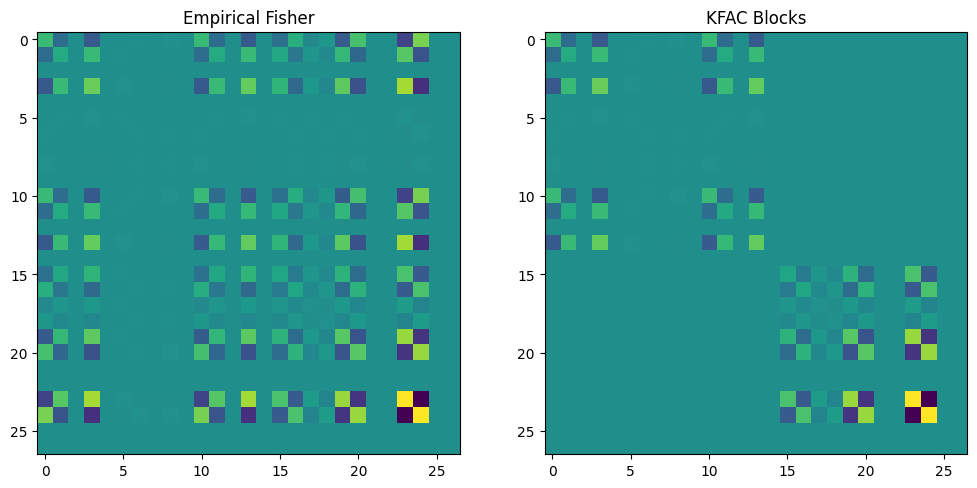

In [34]:
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(EFisher)
ax1.set_title('Empirical Fisher')

kfac = jnp.zeros_like(EFisher)
idx = 0
for b in blocks:
    kfac = kfac.at[idx: idx+b.shape[0], idx: idx+b.shape[1]].set(b)
    idx += b.shape[0]
ax2.imshow(kfac)
ax2.set_title('KFAC Blocks')

plt.show()

We can see that as described in F. Dangel's tutorial, for a single Datapoint, the blocks of the Fisher and the KFAC conincide. If we repeat for more datapoints, we start to see differences.

#### Limitations

A limitation of the current implementation of `intergrad` is that we assume the network only contains Linear layers with bias. There isn't a mechanism to "parse" out layers for which KFAC is supported like in `kfac-jax` or `laplace-torch` for example.